<a href="https://colab.research.google.com/github/MedJelil/ai-assistant/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.width", 400)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
full_train = pd.read_csv("/content/drive/MyDrive/home-data-for-ml-course/train.csv", index_col=["Id"])

In [3]:
def check_df(dataframe, head=5):
    """
    Performs a comprehensive check on a pandas DataFrame by displaying key information.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame to be analyzed
    head : int, optional (default=5)
        Number of rows to display in head and tail sections

    Returns
    -------
    None
        Prints formatted information about the DataFrame
    """
    # Input validation
    if not isinstance(dataframe, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    if not isinstance(head, int) or head < 1:
        raise ValueError("head must be a positive integer")

    def print_section_header(number, title):
        """Helper function to print consistent section headers"""
        print(f"\n{number} {title}")
        print("▰▱" * 35)

    print("\n📊 DataFrame Quick Overview")
    print("▰" * 70)

    # Basic Information
    print_section_header("1️⃣", "Basic Information")
    print(f"Number of Rows: {dataframe.shape[0]:,}")
    print(f"Number of Columns: {dataframe.shape[1]:,}")

    # Data Types Analysis
    print_section_header("2️⃣", "Data Types")
    dtype_df = pd.DataFrame({
        'Data Type': dataframe.dtypes,
        'Non-Null Count': dataframe.count(),
        'Null Count': dataframe.isnull().sum(),
        'Null Ratio(%)': (dataframe.isnull().sum() / len(dataframe) * 100).round(2).astype(str) + '%'
    }).reset_index().rename(columns={'index': 'Column'})
    print(dtype_df.to_string(index=False))

    # Head and Tail
    print_section_header("3️⃣", f"First {head} Rows")
    print(dataframe.head(head))

    print_section_header("4️⃣", f"Last {head} Rows")
    print(dataframe.tail(head))

    # Numeric Analysis
    numeric_cols = dataframe.select_dtypes(include=[int, float]).columns
    if len(numeric_cols) > 0:
        print_section_header("5️⃣", "Numeric Columns Analysis")
        desc_df = (dataframe[numeric_cols]
                  .describe([0, 0.05, 0.50, 0.95, 0.99, 1])
                  .T
                  .round(2))
        desc_df['count'] = desc_df['count'].astype(int)
        print(desc_df)

    # Memory Usage
    print_section_header("6️⃣", "Memory Usage")
    memory_usage = dataframe.memory_usage(deep=True).sum() / 1024**2
    print(f"Total Memory Usage: {memory_usage:.2f} MB")

    # Detailed Memory Usage
    memory_by_column = dataframe.memory_usage(deep=True) / 1024**2
    print("\nMemory Usage by Column (MB):")
    for col, mem in memory_by_column.items():
        print(f"▫️ {col}: {mem:.2f} MB")

    print("\n" + "▰" * 70)

In [4]:
check_df(full_train)


📊 DataFrame Quick Overview
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

1️⃣ Basic Information
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱
Number of Rows: 1,460
Number of Columns: 80

2️⃣ Data Types
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱
       Column Data Type  Non-Null Count  Null Count Null Ratio(%)
   MSSubClass     int64            1460           0          0.0%
     MSZoning    object            1460           0          0.0%
  LotFrontage   float64            1201         259        17.74%
      LotArea     int64            1460           0          0.0%
       Street    object            1460           0          0.0%
        Alley    object              91        1369        93.77%
     LotShape    object            1460           0          0.0%
  LandContour    object            1460           0          0.0%
    Utilities    object            1460           0          0.0%
    LotConfig   

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric, and categorical but cardinal variables in the dataset.
    Also prints suspicious variables (numeric with few unique values but not strictly sequential).

    Parameters
    ----------
    dataframe : pandas.DataFrame
        DataFrame from which variable names are to be extracted
    cat_th : int, float
        Class threshold for numeric but categorical variables
    car_th : int, float
        Class threshold for categorical but cardinal variables

    Returns
    -------
    cat_cols : list
        List of categorical variables
    num_cols : list
        List of numerical variables
    cat_but_car : list
        List of categorical looking cardinal variables
    """

    # Categorical variable analysis
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes in [int, float]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Numeric variable analysis
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in [int, float]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Suspicious variable check
    suspect_num = []
    for col in num_but_cat:
        unique_vals = sorted(dataframe[col].dropna().unique())
        if all(isinstance(x, int) for x in unique_vals) and min(unique_vals) >= 0:
            # Check if values are strictly sequential (e.g., [0,1,2,3])
            if unique_vals != list(range(min(unique_vals), max(unique_vals)+1)):
                suspect_num.append(col)
        else:
            suspect_num.append(col)

    print("\n📊 Variable Analysis Report")
    print("▰" * 50)

    print("\n1️⃣ General Overview")
    print("▰▱" * 25)
    print(f"Total Observations: {dataframe.shape[0]:,}")
    print(f"Total Variables: {dataframe.shape[1]}")

    print("\n2️⃣ Variable Types")
    print("▰▱" * 25)
    print(f"Categorical Variables: {len(cat_cols)}")
    print(f"Numerical Variables: {len(num_cols)}")
    print(f"Cardinal Variables: {len(cat_but_car)}")
    print(f"Numerical but Categorical: {len(num_but_cat)}")

    print("\n3️⃣ Variable Details")
    print("▰▱" * 25)

    if len(cat_cols) > 0:
        print("\nCategorical Variables:")
        for col in cat_cols:
            if col not in num_but_cat:  # Show only true categorical variables
                print(f"▫️ {col}: {dataframe[col].nunique()} unique values")

    if len(num_cols) > 0:
        print("\nNumerical Variables:")
        for col in num_cols:
            print(f"▫️ {col}: {dataframe[col].nunique()} unique values")

    if len(num_but_cat) > 0:
        print("\nNumerical but Categorical Variables:")
        for col in num_but_cat:
            print(f"▫️ {col}: {dataframe[col].nunique()} unique values")

    if len(cat_but_car) > 0:
        print("\nCardinal Variables:")
        for col in cat_but_car:
            print(f"▫️ {col}: {dataframe[col].nunique()} unique values")

    # Print suspicious variables
    if len(suspect_num) > 0:
        print("\n⚠️ Suspicious variables (numeric with few unique values but not strictly sequential):")
        for col in suspect_num:
            print(f"  {col}: unique values -> {dataframe[col].unique()}")

    print("\n" + "▰" * 50)

    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(full_train, cat_th=10, car_th=30)


📊 Variable Analysis Report
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

1️⃣ General Overview
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱
Total Observations: 1,460
Total Variables: 80

2️⃣ Variable Types
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱
Categorical Variables: 54
Numerical Variables: 26
Cardinal Variables: 0
Numerical but Categorical: 11

3️⃣ Variable Details
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

Categorical Variables:
▫️ MSZoning: 5 unique values
▫️ Street: 2 unique values
▫️ Alley: 2 unique values
▫️ LotShape: 4 unique values
▫️ LandContour: 4 unique values
▫️ Utilities: 2 unique values
▫️ LotConfig: 5 unique values
▫️ LandSlope: 3 unique values
▫️ Neighborhood: 25 unique values
▫️ Condition1: 9 unique values
▫️ Condition2: 8 unique values
▫️ BldgType: 5 unique values
▫️ HouseStyle: 8 unique values
▫️ RoofStyle: 6 unique values
▫️ RoofMatl: 8 unique values
▫️ Exterior1st: 15 unique values
▫️ Exterior2nd: 16 unique values
▫️ MasVnrType: 3 u

In [7]:
suspect_cols = ["MSSubClass", "OverallQual", "MoSold",
                "BsmtFullBath", "BsmtHalfBath", "FullBath",
                "HalfBath", "BedroomAbvGr", "KitchenAbvGr",
                "Fireplaces", "GarageCars", "PoolArea", "YrSold"]

In [8]:
for col in suspect_cols:
    if col in cat_cols:
        cat_cols.remove(col)
        if col not in num_cols:
            num_cols.append(col)

    elif col in num_cols:
        num_cols.remove(col)
        if col not in cat_cols:
            cat_cols.append(col)

In [9]:
len( num_cols) + len(cat_cols)

80

In [10]:
def cat_summary(dataframe, categorical_cols, plot=False, plot_type='vertical', subplot_cols=3):
    """
    Provides detailed summary statistics and visualization for categorical variables.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        DataFrame containing the categorical columns
    categorical_cols : str or list
        Column name(s) to analyze
    plot : bool, optional (default=False)
        Whether to create visualization
    plot_type : str, optional (default='vertical')
        Plot layout type ('vertical' or 'subplot')
    subplot_cols : int, optional (default=3)
        Number of columns in subplot grid
    """
    # Input validation
    if not isinstance(dataframe, pd.DataFrame):
        raise TypeError("dataframe must be a pandas DataFrame")

    categorical_cols = [categorical_cols] if isinstance(categorical_cols, str) else categorical_cols

    # Define color palette
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC',
              '#99CCFF', '#FFB366', '#FF99FF', '#99FF99', '#FFB3B3']

    def print_column_stats(col_name, stats_df):
        """Inner function to print column statistics"""
        print(f"\n📈 Analysis of {col_name}")
        print("▰▱" * 25)

        value_counts = dataframe[col_name].value_counts()

        print("\n📊 Distribution Statistics:")
        print(f"▫️ Total Unique Values: {dataframe[col_name].nunique()}")
        print(f"▫️ Most Common Value: {value_counts.index[0]} ({value_counts.iloc[0]} occurrences)")
        print(f"▫️ Least Common Value: {value_counts.index[-1]} ({value_counts.iloc[-1]} occurrences)")

        print("\n📋 Detailed Breakdown:")
        print(stats_df)
        print("\n" + "▰" * 50)

    def create_vertical_plots():
        """Inner function for vertical plots"""
        heights = [max(4, dataframe[col].nunique() * 0.5) for col in categorical_cols]
        plt.figure(figsize=(12, sum(heights)))

        for idx, col in enumerate(categorical_cols, 1):
            plt.subplot(len(categorical_cols), 1, idx)
            create_single_plot(col)

        plt.tight_layout(h_pad=3.0)
        plt.show(block=True)

    def create_subplot_plots():
        """Inner function for subplot grid"""
        n_rows = math.ceil(len(categorical_cols) / subplot_cols)
        n_cols = subplot_cols

        max_cats = max(dataframe[col].nunique() for col in categorical_cols)
        fig_width = max(6 * n_cols, max_cats * 0.7 * n_cols)
        fig_height = max(4 * n_rows, max_cats * 0.5 * n_rows)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
        axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else [axes]

        for idx, col in enumerate(categorical_cols):
            create_single_plot(col, axes[idx])

        # Hide unused subplots
        for ax in axes[len(categorical_cols):]:
            ax.set_visible(False)

        plt.tight_layout(h_pad=2.0, w_pad=3.0)
        plt.show(block=True)

    def create_single_plot(col, ax=None):
        """Inner function to create a single categorical plot"""
        if ax is None:
            ax = plt.gca()

        value_counts = dataframe[col].value_counts()
        n_categories = len(value_counts)
        col_colors = colors[:n_categories]

        sns.countplot(x=dataframe[col], order=value_counts.index,
                     palette=col_colors, ax=ax)
        ax.set_title(f"Distribution of {col}")

        # Rotate labels if needed
        if dataframe[col].nunique() > 5:
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # Add value labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom')

        # Add ratio information
        counts = dataframe[col].value_counts()
        ratio = counts / len(dataframe)
        stats_text = "Category Ratios:\n"
        for (cat, count), color in zip(counts.items(), col_colors):
            stats_text += f'█ {cat}: {ratio[cat]:.1%}\n'

        ax.text(1.02, 0.5, stats_text,
                transform=ax.transAxes,
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Main execution
    print("\n📊 Categorical Variables Analysis Report")
    print("▰" * 50)

    for col in categorical_cols:
        if dataframe[col].dtypes == "bool":
            dataframe[col] = dataframe[col].astype(int)

        # Calculate statistics
        value_counts = dataframe[col].value_counts()
        ratios = 100 * value_counts / len(dataframe)

        # Create summary DataFrame
        summary_df = pd.DataFrame({
            "Count": value_counts,
            "Ratio (%)": ratios.round(2).astype(str) + '%',
            "Cumulative Ratio (%)": ratios.cumsum().round(2).astype(str) + '%'
        })

        print_column_stats(col, summary_df)

    if plot:
        if plot_type == 'vertical':
            create_vertical_plots()
        elif plot_type == 'subplot':
            create_subplot_plots()
        else:
            raise ValueError("plot_type must be either 'vertical' or 'subplot'")

In [12]:
cat_summary(full_train, cat_cols, plot=True, plot_type="subplot")


📊 Categorical Variables Analysis Report
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

📈 Analysis of MSZoning
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📊 Distribution Statistics:
▫️ Total Unique Values: 5
▫️ Most Common Value: RL (1151 occurrences)
▫️ Least Common Value: C (all) (10 occurrences)

📋 Detailed Breakdown:
          Count Ratio (%) Cumulative Ratio (%)
MSZoning                                      
RL         1151    78.84%               78.84%
RM          218    14.93%               93.77%
FV           65     4.45%               98.22%
RH           16      1.1%               99.32%
C (all)      10     0.68%               100.0%

▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

📈 Analysis of Street
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📊 Distribution Statistics:
▫️ Total Unique Values: 2
▫️ Most Common Value: Pave (1454 occurrences)
▫️ Least Common Value: Grvl (6 occurrences)

📋 Detailed Breakdown:
        Count Ratio (%) Cumulative Ratio (%

In [13]:
def num_summary(dataframe, numerical_cols, plot=False, plot_type='vertical', subplot_cols=3):
    """
    Provides detailed summary statistics and visualization for numerical variables.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        DataFrame containing the numerical columns
    numerical_cols : str or list
        Column name(s) to analyze
    plot : bool, optional (default=False)
        Whether to create visualization
    plot_type : str, optional (default='vertical')
        Plot layout type ('vertical' or 'subplot')
    subplot_cols : int, optional (default=3)
        Number of columns in subplot grid
    """
    numerical_cols = [numerical_cols] if isinstance(numerical_cols, str) else numerical_cols

    def print_column_analysis(col):
        """Inner function to print column analysis"""
        print(f"\n📈 Analysis of {col}")
        print("▰▱" * 25)

        # Calculate statistics
        stats = dataframe[col].describe()
        quantiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
        quant = dataframe[col].quantile(quantiles)

        print("\n📊 Basic Statistics:")
        print(f"▫️ Count: {stats['count']:,.0f}")
        print(f"▫️ Mean: {stats['mean']:,.2f}")
        print(f"▫️ Std: {stats['std']:,.2f}")
        print(f"▫️ Min: {stats['min']:,.2f}")
        print(f"▫️ Max: {stats['max']:,.2f}")


        print("\n📋 Normality Test:", end=" ")
        statistic, p_value = shapiro(dataframe[col].values)  # Using .values to get numpy array
        if p_value > 0.05:
            print("✅")  # Green tick for normal distribution
        else:
            print("❌")  # Red X for non-normal distribution

        print("\n📊 Quantile Analysis:")
        print("-" * 40)
        print(f"{'Percentile':>12} {'Value':>15}")
        print("-" * 40)
        for q, val in quant.items():
            print(f"{q*100:>11.0f}% {val:>15,.2f}")

        print("\n" + "▰" * 50)

    def create_histogram(col, ax=None):
        """Inner function to create histogram with KDE"""
        if ax is None:
            ax = plt.gca()

        # Create histogram with density
        sns.histplot(data=dataframe, x=col, stat='density',
                    color='lightblue', alpha=0.5, ax=ax)

        # Add KDE plot
        sns.kdeplot(data=dataframe[col], color='red', linewidth=2, ax=ax)

        # Add title
        ax.set_title(f"Distribution of {col}")

        # Add statistical annotations
        stats_text = (
            f'Mean: {dataframe[col].mean():.2f}\n'
            f'Std: {dataframe[col].std():.2f}\n'
            f'Median: {dataframe[col].median():.2f}'
        )

        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    def create_plots():
        """Inner function to handle plot creation"""
        if plot_type == 'vertical':
            total_height = len(numerical_cols) * 5
            plt.figure(figsize=(10, total_height))

            for idx, col in enumerate(numerical_cols, 1):
                plt.subplot(len(numerical_cols), 1, idx)
                create_histogram(col)

            plt.tight_layout(h_pad=3.0)
            plt.show(block=True)

        elif plot_type == 'subplot':
            n_rows = math.ceil(len(numerical_cols) / subplot_cols)
            fig_width = subplot_cols * 5
            fig_height = n_rows * 4

            fig, axes = plt.subplots(n_rows, subplot_cols,
                                   figsize=(fig_width, fig_height))
            axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else [axes]

            for idx, col in enumerate(numerical_cols):
                create_histogram(col, axes[idx])

            # Hide unused subplots
            for ax in axes[len(numerical_cols):]:
                ax.set_visible(False)

            plt.tight_layout(h_pad=2.0, w_pad=3.0)
            plt.show(block=True)

        else:
            raise ValueError("plot_type must be either 'vertical' or 'subplot'")

    # Main execution
    print("\n📊 Numerical Variables Analysis Report")
    print("▰" * 50)

    for col in numerical_cols:
        print_column_analysis(col)

    if plot:
        create_plots()


📊 Numerical Variables Analysis Report
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

📈 Analysis of LotFrontage
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📊 Basic Statistics:
▫️ Count: 1,201
▫️ Mean: 70.05
▫️ Std: 24.28
▫️ Min: 21.00
▫️ Max: 313.00

📋 Normality Test: ❌

📊 Quantile Analysis:
----------------------------------------
  Percentile           Value
----------------------------------------
          1%           21.00
          5%           34.00
         10%           44.00
         25%           59.00
         50%           69.00
         75%           80.00
         90%           96.00
         95%          107.00
         99%          141.00

▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

📈 Analysis of LotArea
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📊 Basic Statistics:
▫️ Count: 1,460
▫️ Mean: 10,516.83
▫️ Std: 9,981.26
▫️ Min: 1,300.00
▫️ Max: 215,245.00

📋 Normality Test: ❌

📊 Quantile Analysis:
----------------------------------------
  P

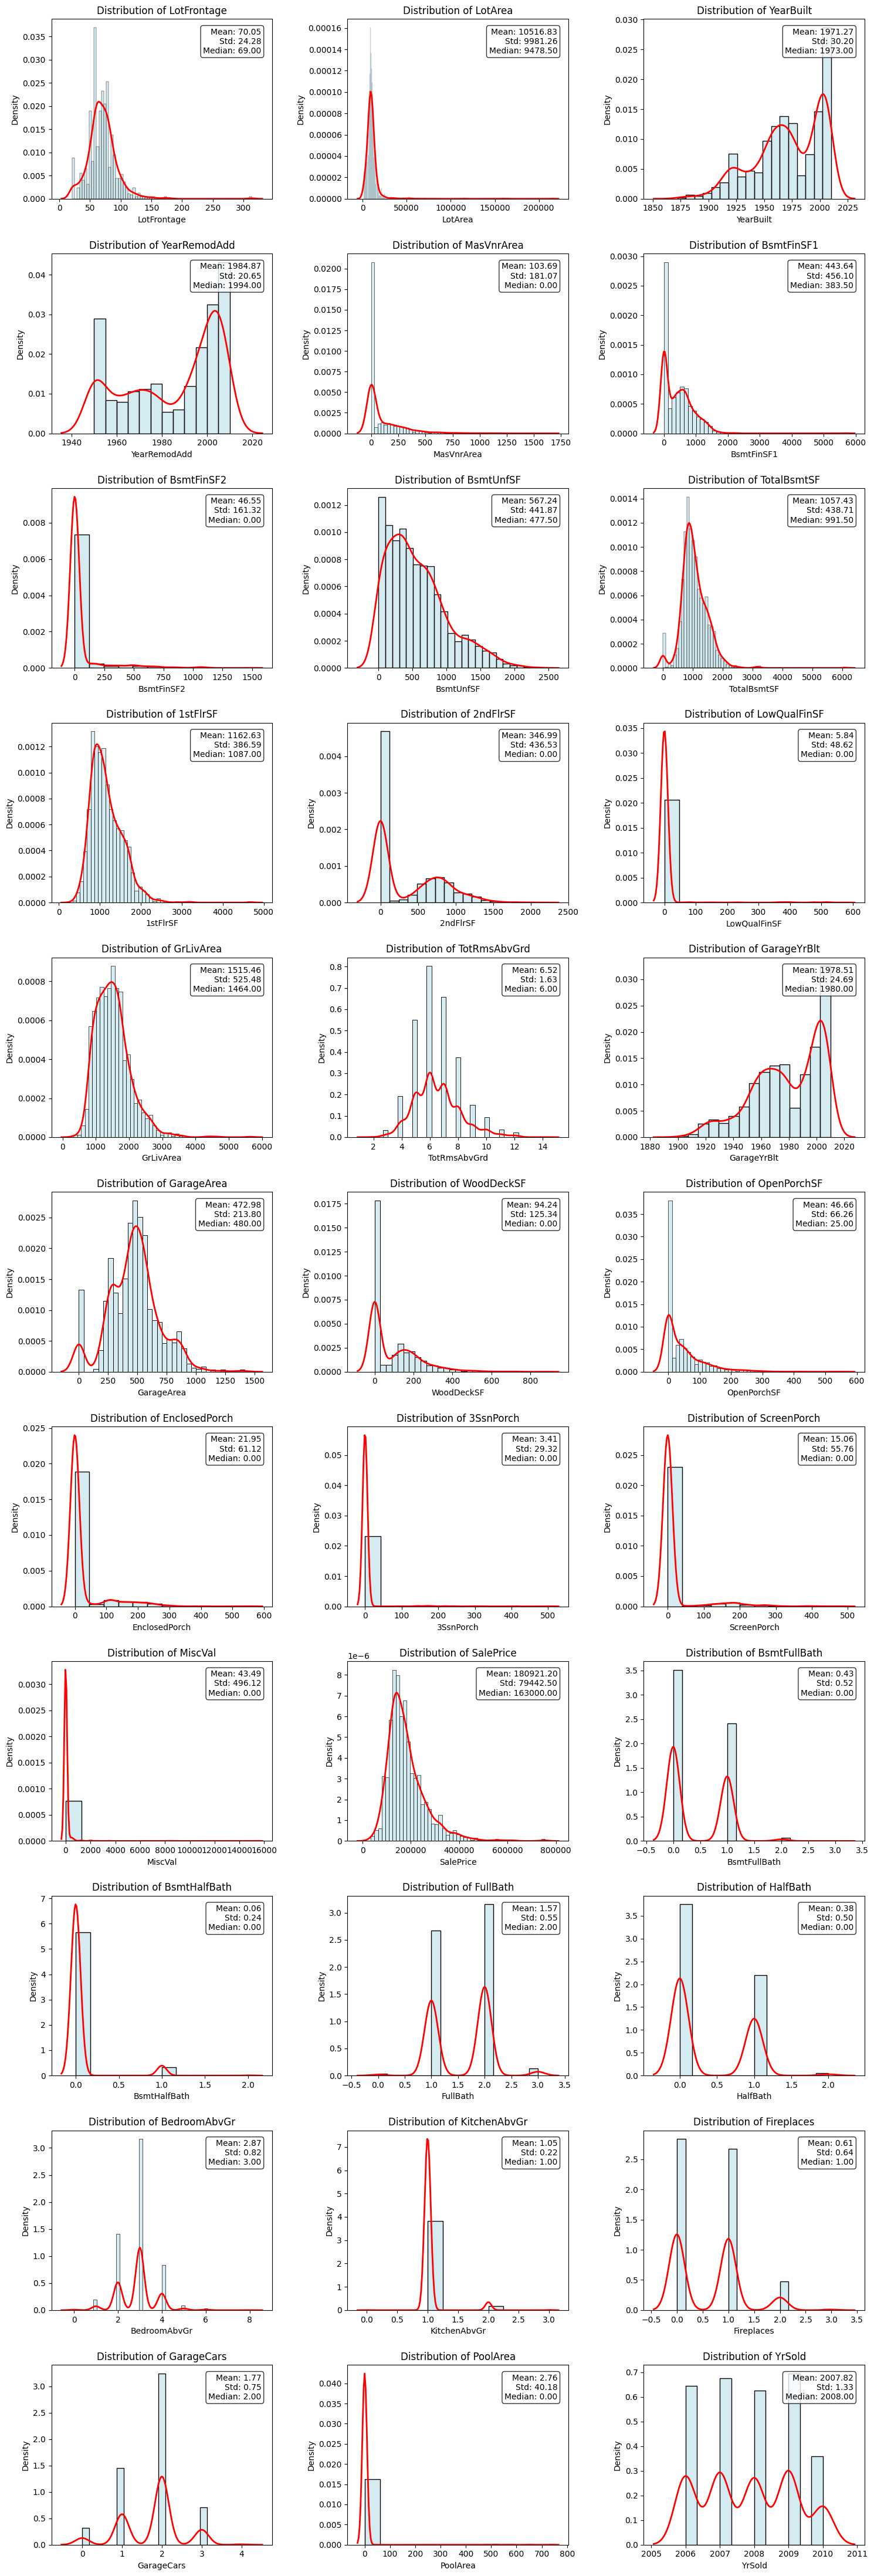

In [14]:
num_summary(full_train, num_cols, plot=True, plot_type="subplot")

In [15]:
def target_summary_with_cat(dataframe, target, categorical_cols, plot=False, plot_type='vertical', subplot_cols=3, is_target_cat=None, max_unique=None):
    """
    Performs comprehensive analysis of relationships between categorical variables and a target variable.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Input DataFrame containing the data
    target : str
        Name of the target variable column
    categorical_cols : str or list
        Single column name or list of categorical column names to analyze
    plot : bool, optional (default=False)
        Whether to create visualization plots
    plot_type : str, optional (default='vertical')
        Type of plot layout ('vertical' or 'subplot')
    subplot_cols : int, optional (default=3)
        Number of columns in subplot grid when plot_type='subplot'
    is_target_cat : bool, optional (default=None)
        Force target variable type. If None, automatically determined
    max_unique : int, optional (default=None)
        Maximum number of unique values for target to be considered categorical

    Returns
    -------
    None
        Prints analysis results and displays plots if plot=True
    """
    def print_section(title, content=""):
        """Helper function to print formatted sections"""
        print(f"\n{title}")
        print("▰▱" * 25)
        if content:
            print(content)

    def analyze_categorical_target(col):
        """Helper function for categorical target analysis"""
        cross_tab = pd.crosstab(dataframe[col], dataframe[target], normalize='index')
        summary_stats = pd.DataFrame({
            'Count': dataframe.groupby(col).size(),
            'Ratio(%)': (100 * dataframe.groupby(col).size() / len(dataframe)).round(2)
        })
        summary_stats['Ratio(%)'] = summary_stats['Ratio(%)'].astype(str) + '%'

        print_section(f"📈 Analysis of {target} by {col}")

        print("\n📊 Basic Statistics:")
        print(f"▫️ Number of Categories in {col}: {dataframe[col].nunique()}")

        print("\n📋 Category Distribution:")
        print("-" * 100)
        print(summary_stats)

        print("\n📊 Target Distribution within Categories (%):")
        print("-" * 100)
        print((cross_tab * 100).round(2).astype(str) + '%')

        print("\n📈 Key Insights:")
        for target_val in dataframe[target].unique():
            max_cat = cross_tab[target_val].idxmax()
            print(f"▫️ Highest {target_val} Ratio: {max_cat} ({cross_tab.loc[max_cat, target_val]:.1%})")

    def analyze_numerical_target(col):
        """Helper function for numerical target analysis"""
        overall_mean = dataframe[target].mean()
        overall_std = dataframe[target].std()

        summary_stats = dataframe.groupby(col).agg({
            target: ['count', 'mean', 'std'],
            col: 'count'
        }).round(3)

        summary_stats.columns = ['Count', 'Target_Mean', 'Target_Std', 'Total']
        summary_stats['Ratio(%)'] = (100 * summary_stats['Count'] / len(dataframe)).round(2)
        summary_stats['Diff_From_Mean(%)'] = (
            100 * (summary_stats['Target_Mean'] - overall_mean) / overall_mean
        ).round(2)

        summary_stats['Ratio(%)'] = summary_stats['Ratio(%)'].astype(str) + '%'
        summary_stats['Diff_From_Mean(%)'] = summary_stats['Diff_From_Mean(%)'].apply(
            lambda x: f"+{x}%" if x > 0 else f"{x}%"
        )

        print_section(f"📈 Analysis of {target} by {col}")

        print("\n📊 Basic Statistics:")
        print(f"▫️ Number of Categories: {dataframe[col].nunique()}")
        print(f"▫️ Overall Target Mean: {overall_mean:.3f}")
        print(f"▫️ Overall Target Std: {overall_std:.3f}")

        print("\n📋 Detailed Analysis by Category:")
        print("-" * 100)
        print(summary_stats)

        print("\n📈 Key Insights:")
        max_impact = summary_stats['Target_Mean'].idxmax()
        min_impact = summary_stats['Target_Mean'].idxmin()
        print(f"▫️ Highest Target Mean: {max_impact} ({summary_stats.loc[max_impact, 'Target_Mean']:.3f})")
        print(f"▫️ Lowest Target Mean: {min_impact} ({summary_stats.loc[min_impact, 'Target_Mean']:.3f})")
        print(f"▫️ Range of Target Means: {summary_stats['Target_Mean'].max() - summary_stats['Target_Mean'].min():.3f}")

    def create_plots():
        """Helper function to create visualizations"""
        if plot_type == 'vertical':
            create_vertical_plots()
        elif plot_type == 'subplot':
            create_subplot_plots()
        else:
            raise ValueError("plot_type must be either 'vertical' or 'subplot'")

    def create_vertical_plots():
        """Helper function for vertical plots"""
        heights = [max(4, dataframe[col].nunique() * 0.5) for col in categorical_cols]
        plt.figure(figsize=(12, sum(heights)))

        for idx, col in enumerate(categorical_cols, 1):
            plt.subplot(len(categorical_cols), 1, idx)
            create_single_plot(col)

        plt.tight_layout(h_pad=3.0)
        plt.show(block=True)

    def create_subplot_plots():
        """Helper function for subplot grid"""
        n_cols = min(subplot_cols, len(categorical_cols))
        n_rows = math.ceil(len(categorical_cols) / n_cols)

        max_cats = max(dataframe[col].nunique() for col in categorical_cols)
        fig_width = max(6 * n_cols, max_cats * 0.7 * n_cols)
        fig_height = max(4 * n_rows, max_cats * 0.5 * n_rows)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
        axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else [axes]

        for idx, col in enumerate(categorical_cols):
            if idx < len(axes):
                create_single_plot(col, axes[idx])

        for ax in axes[len(categorical_cols):]:
            ax.set_visible(False)

        plt.tight_layout()
        plt.show(block=True)

    def create_single_plot(col, ax=None):
        """Helper function to create a single plot"""
        if ax is None:
            ax = plt.gca()

        if is_target_categorical:
            cross_tab = pd.crosstab(dataframe[col], dataframe[target], normalize='index')
            cross_tab.plot(kind='bar', stacked=True, ax=ax)
            ax.set_title(f"Target Distribution by {col}")
            ax.set_ylabel("Proportion")
        else:
            summary_data = dataframe.groupby(col)[target].mean().reset_index()
            sns.barplot(x=col, y=target, data=summary_data, color='skyblue', ax=ax)
            ax.set_title(f"Mean {target} by {col}")

        if dataframe[col].nunique() > 5:
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Main execution
    categorical_cols = [categorical_cols] if isinstance(categorical_cols, str) else categorical_cols

    # Determine if target is categorical
    if is_target_cat is None:
        is_target_categorical = (
            dataframe[target].dtype in ['object', 'category', 'bool'] or
            dataframe[target].nunique() <= (max_unique if max_unique else 2)
        )
    else:
        is_target_categorical = is_target_cat

    print("\n📊 Target Analysis by Categorical Variables")
    print("▰" * 70)

    print_section("📋 Target Variable Information",
                 f"▫️ Variable Type: {'Categorical' if is_target_categorical else 'Numerical'}\n"
                 f"▫️ Number of Unique Values: {dataframe[target].nunique()}")

    if is_target_categorical:
        target_dist = dataframe[target].value_counts(normalize=True).round(3)
        print_section("📊 Target Distribution",
                     "\n".join(f"▫️ {val}: {prop:.1%}" for val, prop in target_dist.items()))

    for col in categorical_cols:
        if is_target_categorical:
            analyze_categorical_target(col)
        else:
            analyze_numerical_target(col)

    if plot:
        create_plots()

    print("\n" + "▰" * 70)

In [16]:
target_summary_with_cat(full_train, "SalePrice", cat_cols, plot=True, plot_type="subplot", subplot_cols=2, is_target_cat=False)


📊 Target Analysis by Categorical Variables
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

📋 Target Variable Information
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱
▫️ Variable Type: Numerical
▫️ Number of Unique Values: 663

📈 Analysis of SalePrice by MSZoning
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📊 Basic Statistics:
▫️ Number of Categories: 5
▫️ Overall Target Mean: 180921.196
▫️ Overall Target Std: 79442.503

📋 Detailed Analysis by Category:
----------------------------------------------------------------------------------------------------
          Count  Target_Mean  Target_Std  Total Ratio(%) Diff_From_Mean(%)
MSZoning                                                                  
C (all)      10    74528.000   33791.092     10    0.68%           -58.81%
FV           65   214014.062   52369.662     65    4.45%           +18.29%
RH           16   131558.375   35714.118     16     1.1%           -27.28%
RL         1151   191004.995 


▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰


In [17]:
def target_summary_with_num(dataframe, target, numerical_cols, is_target_cat=None, max_unique=None):
    """
    Analyzes the relationship between target variable and numerical variables.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data
    target : str
        Name of the target variable column
    numerical_cols : str or list
        Single column name or list of numerical column names to analyze
    is_target_cat : bool, optional
        If True, target is treated as categorical
        If False, target is treated as numerical
        If None, type is automatically detected (default)
    max_unique : int, optional
        Maximum unique values for target to be considered categorical
    """
    def print_section(title, content=""):
        """Helper function to print formatted sections"""
        print(f"\n{title}")
        print("▰▱" * 25)
        if content:
            print(content)

    def analyze_categorical_target(col):
        """Helper function for categorical target analysis"""
        stats = dataframe.groupby(target)[col].agg(['count', 'mean', 'median',
                                                   'min', 'max', 'std']).round(2)

        # Calculate additional metrics
        stats['ratio'] = (100 * stats['count'] / len(dataframe)).round(2)
        stats['ratio'] = stats['ratio'].astype(str) + '%'

        overall_mean = dataframe[col].mean()
        stats['diff_from_mean'] = (100 * (stats['mean'] - overall_mean) / overall_mean).round(2)
        stats['diff_from_mean'] = stats['diff_from_mean'].apply(
            lambda x: f"+{x}%" if x > 0 else f"{x}%")

        print_section(f"📈 Analysis of {col} by {target}")

        # Print summary statistics
        print("\n📊 Summary Statistics by Target Class:")
        print(stats.rename(columns={
            'count': 'Count',
            'mean': 'Mean',
            'median': 'Median',
            'min': 'Min',
            'max': 'Max',
            'std': 'Std',
            'ratio': 'Ratio(%)',
            'diff_from_mean': 'Diff from Mean(%)'
        }))

        # Print insights
        print("\n📈 Key Insights:")
        print(f"▫️ Overall Mean: {overall_mean:.2f}")
        print(f"▫️ Class with Highest Mean: {stats['mean'].idxmax()} ({stats['mean'].max():.2f})")
        print(f"▫️ Class with Lowest Mean: {stats['mean'].idxmin()} ({stats['mean'].min():.2f})")
        print(f"▫️ Mean Range: {stats['mean'].max() - stats['mean'].min():.2f}")

    def analyze_numerical_target(col):
        """Helper function for numerical target analysis"""
        print_section(f"📈 Analysis of {col}")

        # Calculate statistics
        stats = dataframe[col].agg(['mean', 'std', 'min', 'max']).round(2)
        quartiles = dataframe[col].quantile([0.25, 0.5, 0.75]).round(2)

        # Calculate correlation
        correlation = dataframe[[target, col]].corr().iloc[0, 1].round(3)

        print("\n📋 Distribution Statistics:")
        print(f"▫️ Mean: {stats['mean']}")
        print(f"▫️ Std: {stats['std']}")
        print(f"▫️ Q1 (25%): {quartiles[0.25]}")
        print(f"▫️ Median: {quartiles[0.5]}")
        print(f"▫️ Q3 (75%): {quartiles[0.75]}")
        print(f"▫️ IQR: {(quartiles[0.75] - quartiles[0.25]):.2f}")
        print(f"▫️ Correlation with target: {correlation}")

    # Input validation and preprocessing
    numerical_cols = [numerical_cols] if isinstance(numerical_cols, str) else numerical_cols

    # Determine if target is categorical
    if is_target_cat is None:
        is_target_categorical = (
            dataframe[target].dtype in ['object', 'category', 'bool'] or
            dataframe[target].nunique() <= (max_unique if max_unique else 2)
        )
    else:
        is_target_categorical = is_target_cat

    # Print main header
    print("\n📊 Target-Based Numerical Analysis Report")
    print("▰" * 70)

    # Print target information
    print_section("📋 Target Variable Information",
                 f"▫️ Variable Type: {'Categorical' if is_target_categorical else 'Numerical'}\n"
                 f"▫️ Unique Values: {dataframe[target].nunique()}")

    # Print target distribution if categorical
    if is_target_categorical:
        target_dist = pd.DataFrame({
            "Count": dataframe[target].value_counts(),
            "Ratio": (100 * dataframe[target].value_counts() / len(dataframe)).round(2)
        })
        target_dist["Ratio"] = target_dist["Ratio"].astype(str) + '%'
        print_section("📊 Target Class Distribution", target_dist.to_string())

    # Analyze each numerical column
    for col in numerical_cols:
        if is_target_categorical:
            analyze_categorical_target(col)
        else:
            analyze_numerical_target(col)

    print("\n" + "▰" * 70)

In [18]:
target_summary_with_num(full_train,
                        "SalePrice",
                        numerical_cols = [col for col in num_cols if col!="SalePrice"],
                        is_target_cat=False)


📊 Target-Based Numerical Analysis Report
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

📋 Target Variable Information
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱
▫️ Variable Type: Numerical
▫️ Unique Values: 663

📈 Analysis of LotFrontage
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📋 Distribution Statistics:
▫️ Mean: 70.05
▫️ Std: 24.28
▫️ Q1 (25%): 59.0
▫️ Median: 69.0
▫️ Q3 (75%): 80.0
▫️ IQR: 21.00
▫️ Correlation with target: 0.352

📈 Analysis of LotArea
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📋 Distribution Statistics:
▫️ Mean: 10516.83
▫️ Std: 9981.26
▫️ Q1 (25%): 7553.5
▫️ Median: 9478.5
▫️ Q3 (75%): 11601.5
▫️ IQR: 4048.00
▫️ Correlation with target: 0.264

📈 Analysis of YearBuilt
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📋 Distribution Statistics:
▫️ Mean: 1971.27
▫️ Std: 30.2
▫️ Q1 (25%): 1954.0
▫️ Median: 1973.0
▫️ Q3 (75%): 2000.0
▫️ IQR: 46.00
▫️ Correlation with target: 0.523

📈 Analysis of YearRemodAdd
▰▱▰▱▰▱▰

In [19]:
def plot_target_correlations(dataframe, numeric_cols, target, top_n=10, figsize=(12, 6)):
    """
    Plots and analyzes correlations between numeric columns and the target variable.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Input DataFrame containing the data
    numeric_cols : list
        List of numeric column names to analyze
    target : str
        Name of the target variable
    top_n : int, optional (default=10)
        Number of top correlations to show (half positive, half negative)
        Must be an even number
    figsize : tuple, optional (default=(12, 6))
        Figure size for the correlation plot (width, height)

    Returns
    -------
    pandas.Series
        Top correlations (both positive and negative) with the target variable

    Examples
    --------
    >>> plot_target_correlations(df, numeric_cols, 'target', top_n=6)  # Shows top 3 positive and negative
    >>> plot_target_correlations(df, numeric_cols, 'target', top_n=4)  # Shows top 2 positive and negative
    """

    # Input validation
    if not isinstance(dataframe, pd.DataFrame):
        raise TypeError("dataframe must be a pandas DataFrame")
    if target not in dataframe.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame")
    if not all(col in dataframe.columns for col in numeric_cols):
        raise ValueError("Some numeric columns not found in DataFrame")
    if top_n % 2 != 0:
        top_n = top_n + 1
        print(f"Warning: top_n must be even. Adjusted to {top_n}")

    # Calculate correlations
    correlations = dataframe[numeric_cols].corrwith(dataframe[target])
    correlations = correlations.sort_values(ascending=True)

    # Get top correlations (including both positive and negative)
    half_n = top_n // 2
    top_correlations = pd.concat([
        correlations.head(half_n),  # Top negative correlations
        correlations.tail(half_n)   # Top positive correlations
    ])

    # Create visualization
    plt.figure(figsize=figsize)

    # Plot bars
    bars = plt.barh(
        range(len(top_correlations)),
        top_correlations,
        color=['#FF9999' if x < 0 else '#66B2FF' for x in top_correlations]
    )

    # Customize plot
    plt.yticks(range(len(top_correlations)), top_correlations.index)
    plt.xlabel(f'Correlation with {target}')
    plt.title(f'Top {top_n} Correlations with {target}  positive and negative')

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(
            width * (1.01 if width >= 0 else 0.99),
            bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left' if width >= 0 else 'right',
            va='center'
        )

    # Add vertical line at x=0
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    # Add grid
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Adjust layout and display
    plt.tight_layout()

    # Print additional information
    print("\n📊 Correlation Analysis Summary")
    print("=" * 50)
    print(f"\n🔵 Top {half_n} Positive Correlations:")
    for idx, (col, corr) in enumerate(correlations.tail(half_n)[::-1].items(), 1):
        print(f"{idx}. {col}: {corr:.3f}")

    print(f"\n🔴 Top {half_n} Negative Correlations:")
    for idx, (col, corr) in enumerate(correlations.head(half_n).items(), 1):
        print(f"{idx}. {col}: {corr:.3f}")

    return top_correlations


📊 Correlation Analysis Summary

🔵 Top 10 Positive Correlations:
1. GrLivArea: 0.709
2. GarageCars: 0.640
3. GarageArea: 0.623
4. TotalBsmtSF: 0.614
5. 1stFlrSF: 0.606
6. FullBath: 0.561
7. TotRmsAbvGrd: 0.534
8. YearBuilt: 0.523
9. YearRemodAdd: 0.507
10. GarageYrBlt: 0.486

🔴 Top 10 Negative Correlations:
1. KitchenAbvGr: -0.136
2. EnclosedPorch: -0.129
3. YrSold: -0.029
4. LowQualFinSF: -0.026
5. MiscVal: -0.021
6. BsmtHalfBath: -0.017
7. BsmtFinSF2: -0.011
8. 3SsnPorch: 0.045
9. PoolArea: 0.092
10. ScreenPorch: 0.111


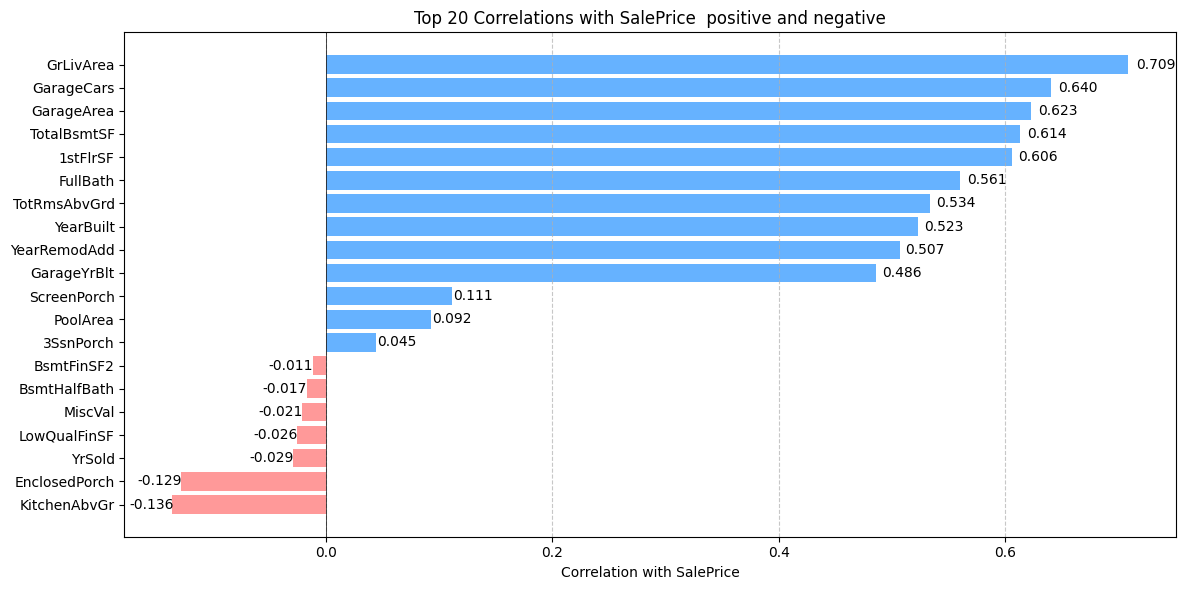

In [20]:
base_corr_df = plot_target_correlations(full_train,
                         numeric_cols=[col for col in num_cols if col !="SalePrice"],
                         target="SalePrice",
                         top_n=20)

In [21]:
def plot_shap_feature_importance(model, X, y=None, feature_names=None, max_display=20,
                               plot_type='bar', show_numbers=True, fig_size=(12, 8)):
    """
    Visualize feature importance using SHAP (SHapley Additive exPlanations) values.

    This function provides various visualization options for feature importance analysis
    using SHAP values, supporting both tree-based and deep learning models.

    Parameters
    ----------
    model : object
        Trained machine learning model (works best with tree-based models like
        XGBoost, LightGBM, or RandomForest)
    X : pandas.DataFrame or numpy.ndarray
        Feature dataset for which SHAP values will be calculated
    y : array-like, optional (default=None)
        Target values, required for some specific SHAP explainer types
    feature_names : list, optional (default=None)
        List of feature names. If None, will use X.columns if X is a DataFrame
    max_display : int, optional (default=20)
        Maximum number of features to display in the plot
    plot_type : str, optional (default='bar')
        Type of plot to create. Options:
        - 'bar': Horizontal bar plot
        - 'beeswarm': SHAP's beeswarm plot
        - 'violin': SHAP's violin plot
    show_numbers : bool, optional (default=True)
        Whether to show numerical values on the bar plot
    fig_size : tuple, optional (default=(12, 8))
        Figure size in inches (width, height)

    Returns
    -------
    tuple
        (shap_values, feature_importance_df)
        - shap_values: Calculated SHAP values
        - feature_importance_df: DataFrame containing feature importance metrics

    Raises
    ------
    ImportError
        If required packages are not installed
    ValueError
        If invalid parameters are provided
    Exception
        For other unexpected errors during execution

    Notes
    -----
    - For classification tasks, average absolute SHAP values across classes are used
    - The function works best with tree-based models but can adapt to other model types
    - Large datasets might require significant computation time

    Examples
    --------
    >>> from sklearn.ensemble import RandomForestRegressor
    >>> model = RandomForestRegressor().fit(X_train, y_train)
    >>> shap_values, importance_df = plot_shap_feature_importance(
    ...     model, X_val, max_display=15, plot_type='bar'
    ... )
    """

    # Input validation
    if not isinstance(max_display, int) or max_display <= 0:
        raise ValueError("max_display must be a positive integer")

    if plot_type not in ['bar', 'beeswarm', 'violin']:
        raise ValueError("plot_type must be one of: 'bar', 'beeswarm', 'violin'")

    # Handle feature names
    if feature_names is None:
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns.tolist()
        else:
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    try:
        # Initialize SHAP explainer based on model type
        if str(type(model)).find('xgboost') != -1:
            explainer = shap.TreeExplainer(model)
        elif str(type(model)).find('lightgbm') != -1:
            explainer = shap.TreeExplainer(model)
        elif str(type(model)).find('RandomForest') != -1:
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.KernelExplainer(model.predict, X)

        # Calculate SHAP values
        shap_values = explainer.shap_values(X)

        # Handle multi-class output
        if isinstance(shap_values, list):
            shap_values = np.abs(np.array(shap_values)).mean(0)

        # Calculate feature importance
        feature_importance = np.abs(shap_values).mean(0)
        feature_importance_dict = dict(zip(feature_names, feature_importance))

        # Create DataFrame with feature importance metrics
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance,
            'Absolute_Importance': np.abs(feature_importance)
        }).sort_values('Absolute_Importance', ascending=False)

        # Plotting
        plt.figure(figsize=fig_size)

        if plot_type == 'bar':
            # Create horizontal bar plot
            importance_df_display = importance_df.head(max_display)
            sns.barplot(data=importance_df_display,
                       y='Feature',
                       x='Absolute_Importance',
                       palette='viridis')

            if show_numbers:
                for i, v in enumerate(importance_df_display['Absolute_Importance']):
                    plt.text(v, i, f' {v:.3f}', va='center')

            plt.title('Feature Importance (SHAP Values)')
            plt.xlabel('Mean |SHAP| Value')

        elif plot_type == 'beeswarm':
            shap.summary_plot(shap_values, X, feature_names=feature_names,
                            max_display=max_display, show=False)

        elif plot_type == 'violin':
            shap.summary_plot(shap_values, X, feature_names=feature_names,
                            max_display=max_display, plot_type='violin', show=False)

        plt.tight_layout()
        plt.show()

        return shap_values, importance_df

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print("Note: This function works best with tree-based models.")
        raise

In [22]:
new_full_df = full_train[cat_cols + num_cols]


In [23]:
X = new_full_df.copy()
y = X.pop("SalePrice")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
cat_columns = X.select_dtypes(include=['object', 'category']).columns
X_train_copy = X_train.astype({col: 'category' for col in cat_columns})
X_val_copy = X_val.astype({col: 'category' for col in cat_columns})
base_model = XGBRegressor(
            n_estimators= 100,
            learning_rate= 0.1,
            max_depth= 3,
            random_state= 42,
            verbosity=0,
            enable_categorical= True)
base_model.fit(X_train_copy, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

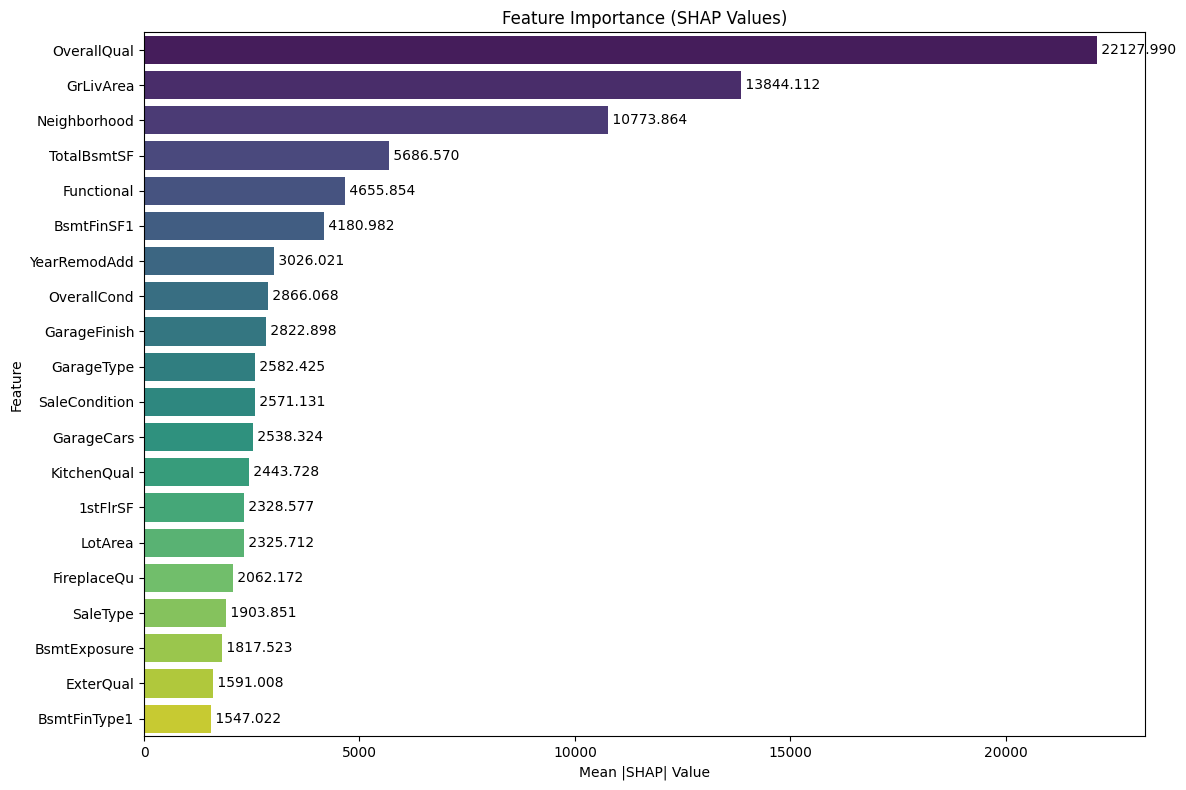

In [24]:
shap_values, base_importance_df = plot_shap_feature_importance(
    base_model, X_val_copy, y=y, max_display=20, plot_type='bar'
)

In [27]:
full_train = pd.read_csv("/content/drive/MyDrive/home-data-for-ml-course/train.csv", index_col=["Id"])

In [30]:
joblib.dump(base_model, "xgb_model.joblib")

['xgb_model.joblib']

In [25]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00


In [37]:
# Sauvegarder les colonnes originales
joblib.dump(X_train.columns.tolist(), "colonnes_attendues.joblib")

['colonnes_attendues.joblib']

In [38]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# Colonnes numériques et catégoriques
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

# Préprocessing
preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# Pipeline complet
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", XGBRegressor())
])

pipeline.fit(X_train, y_train)

# Sauvegarde
joblib.dump(pipeline, "house_price_pipeline.joblib")

['house_price_pipeline.joblib']

In [39]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib

# Charger le pipeline
pipeline = joblib.load("house_price_pipeline.joblib")

# Étape essentielle : récupérer les colonnes d'entrée attendues
# Cela suppose que tu as encore accès à X_train dans ton notebook
# Si ce n’est pas le cas, ajoute ce code AVANT d’entraîner le pipeline :
# joblib.dump(X_train.columns.tolist(), "colonnes_attendues.joblib")
try:
    input_columns = joblib.load("colonnes_attendues.joblib")
except:
    raise ValueError("Tu dois d'abord sauvegarder les colonnes d'entraînement dans 'colonnes_attendues.joblib'.")

def predict_price(OverallQual, GrLivArea, GarageCars, TotalBsmtSF, FullBath,
                  YearBuilt, BedroomAbvGr, KitchenAbvGr, Fireplaces, LotArea):

    # Créer un dictionnaire avec les champs fournis par l'utilisateur
    user_data = {
        "OverallQual": OverallQual,
        "GrLivArea": GrLivArea,
        "GarageCars": GarageCars,
        "TotalBsmtSF": TotalBsmtSF,
        "FullBath": FullBath,
        "YearBuilt": YearBuilt,
        "BedroomAbvGr": BedroomAbvGr,
        "KitchenAbvGr": KitchenAbvGr,
        "Fireplaces": Fireplaces,
        "LotArea": LotArea
    }

    # Créer un DataFrame avec toutes les colonnes attendues
    full_data = {col: [user_data.get(col, np.nan)] for col in input_columns}
    df = pd.DataFrame(full_data)

    # Prédiction
    try:
        prediction = pipeline.predict(df)[0]
        return f"🏠 Valeur estimée : ${prediction:,.2f}"
    except Exception as e:
        return f"❌ Erreur : {str(e)}"

# Interface Gradio
demo = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Slider(1, 10, label="Qualité globale (OverallQual)"),
        gr.Slider(500, 5000, step=10, label="Surface habitable (GrLivArea)"),
        gr.Slider(0, 4, label="Nombre de garages (GarageCars)"),
        gr.Slider(0, 3000, step=10, label="Surface du sous-sol (TotalBsmtSF)"),
        gr.Slider(0, 4, label="Salles de bain complètes (FullBath)"),
        gr.Slider(1870, 2024, label="Année de construction (YearBuilt)"),
        gr.Slider(0, 10, label="Chambres au-dessus du sol (BedroomAbvGr)"),
        gr.Slider(0, 3, label="Cuisines (KitchenAbvGr)"),
        gr.Slider(0, 5, label="Cheminées (Fireplaces)"),
        gr.Slider(1000, 20000, step=100, label="Surface du terrain (LotArea)")
    ],
    outputs="text",
    title="Estimation du Prix Immobilier 🏠",
    description="Remplissez les caractéristiques principales pour obtenir une estimation du prix de la maison."
)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6afb4a0296c36ba487.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
